### Introduction to Natural Language Processing (NLP) - Assignment
#### by Gaurav Singh (grv08singh@gmail.com)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, string
import emoji

import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TextVectorization
from keras import Sequential
from keras.layers import Dense, Embedding, SpatialDropout1D, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

import nltk
from nltk.corpus import stopwords

import warnings as wr
wr.filterwarnings('ignore')

#### Problem Statement:
You are a Data Scientist in a big firm. You have to develop a `deep learning model` to perform `sentiment analysis` on a dataset of `tweets` related to various candidates.

#### Tasks to be Performed:
##### 1) Data Loading and Preprocessing:
* __Load__ the `tweet` data from a `CSV file`.
* __Filter out__ the relevant columns: `candidate`, `sentiment`, and `text`.
* __Preprocess__ the text data by __removing__ `stop words`, `punctuation`, converting to `lowercase`, and other cleaning steps.

In [2]:
nltk.download('stopwords')          #if running for the very first time
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Grv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = (
    pd
    .read_csv("Tweets.csv")[['name','text','airline_sentiment']]
    .drop_duplicates()
    .apply(lambda col : col.str.strip().str.lower())                                 #lowercase
    .assign(text = lambda x : (
        x['text']
        .str.replace("http\S+|www\S+|https\S+|@[a-zA-Z0-9_]+|#|\\d+","",regex=True)  #remove url, nametag, hash symbol, numbers
        .apply(lambda y : " ".join([w for w in y.split() if w not in stop_words]))   #remove stop words
        .apply(lambda y : emoji.replace_emoji(y, ""))
        .str.translate(str.maketrans("","",string.punctuation))                      #remove punctuations
        .str.strip()
        .str.replace("\s+"," ",regex=True)                                           #more than 1 spaces to only 1 space
        
        )
    )
)
for t in df['text']:
    print(t)

said
plus added commercials experience tacky
today must mean need take another trip
really aggressive blast obnoxious entertainment guests faces amp little recourse
really big bad thing
seriously would pay flight seats playing really bad thing flying va
yes nearly every time fly vx “ear worm” won’t go away
really missed prime opportunity men without hats parody there
well didnt…but do d
amazing arrived hour early good me
know suicide second leading cause death among teens
lt pretty graphics much better minimal iconography d
great deal already thinking nd trip amp even gone st trip yet p
flying fabulous seductive skies again u take stress away travel
thanks
sfopdx schedule still mia
excited first cross country flight lax mco heard nothing great things virgin america daystogo
flew nyc sfo last week fully sit seat due two large gentleman either side me help
flying
know would amazingly awesome bosfll please want fly you
first fares may three times carriers seats available select
love graph

##### 2) Text Vectorization:
__Convert__ the preprocessed text data into numerical format using `tokenization` and `padding`, so that it can be fed into a deep learning model.

In [4]:
#length of the review with maximum number of words
max_len = np.max([len(df['text'].str.split()) for df['text'].str in df['text']])

#tokenization
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(df['text'])

#number of unique words in all reviews
vocab_size = len(tokenizer.word_index) + 1

#convert words to numbers
X = tokenizer.texts_to_sequences(df['text'])

#make length of each Integered-Review equal by padding zeros
X_pad = pad_sequences(X, maxlen=max_len)
X_pad.shape

(14500, 21)

##### 3) Model Development:
__Develop__ a deep learning model using `TensorFlow` and `Keras`. The model includes an `Embedding` layer, a `SpatialDropout1D` layer to prevent overfitting, an `LSTM` layer for sequence data processing, and a `Dense` layer for output. It aims to classify the sentiment of each tweet into one of the `three categories`.

In [5]:
#sentiment to integer encoded.
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df['label'] = df['airline_sentiment'].map(sentiment_mapping).astype(int)
#OHE on sentiment with integer datatype
y_cat = to_categorical(df['label'], num_classes = 3)

In [6]:
#build model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##### 4) Model Training and Evaluation:
* __Train__ the model on the processed text data, using `categorical cross-entropy` as the loss function, and `accuracy` as the evaluation metric.
* Use a `validation split` to __evaluate__ the model's performance and prevent overfitting.

In [7]:
#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True
)

In [9]:
#train model
history = model.fit(
    x=X_pad, 
    y=y_cat, 
    batch_size=32, 
    epochs=50, 
    validation_split=0.2, 
    callbacks = [early_stop]
)

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.6523 - loss: 0.8733 - val_accuracy: 0.7945 - val_loss: 0.5949
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7513 - loss: 0.6260 - val_accuracy: 0.7803 - val_loss: 0.5648
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7988 - loss: 0.5350 - val_accuracy: 0.7886 - val_loss: 0.5494
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8258 - loss: 0.4809 - val_accuracy: 0.7872 - val_loss: 0.5537
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8609 - loss: 0.4140 - val_accuracy: 0.7645 - val_loss: 0.6090
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8795 - loss: 0.3669 - val_accuracy: 0.7821 - val_loss: 0.5875
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8931 - loss: 0.3264 - val_accuracy: 0.7945 - val_loss: 0.5988
Epoch 8/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9078 - loss: 0.2908 - v

In [10]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

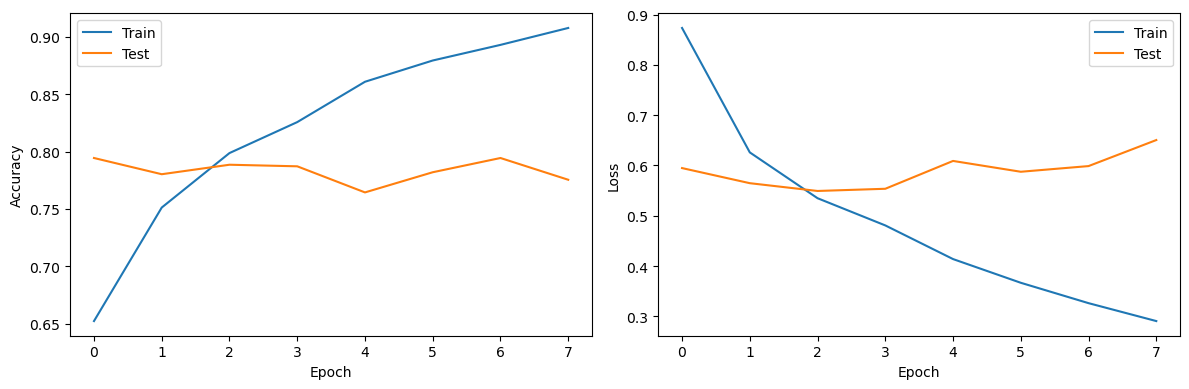

In [11]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(train_acc, label="Train")
ax[0].plot(val_acc, label="Test")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(train_loss, label="Train")
ax[1].plot(val_loss, label="Test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()